# Colored Multiple Shapes

## Import Packages

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import math
from PIL import Image
from skimage import draw
from itertools import permutations
%matplotlib inline

## Data Generation

In [3]:
num_imgs = 50000

img_size = 32
min_object_size = 7
max_object_size = 16
num_objects = 3
num_shapes = 3
num_colors = 3

bboxes = np.zeros((num_imgs, num_objects, 4))
imgs = np.zeros((num_imgs, img_size, img_size, 3)) + 1
shapes = np.zeros((num_imgs, num_objects), dtype = int)
shape_labels = ['rectangle', 'circle', 'triangle']
colors = np.zeros((num_imgs, num_objects), dtype = int)
color_labels = ['r', 'g', 'b']

for i_img in range(num_imgs):
    
    for i_object in range(num_objects):
        shape = np.random.randint(num_shapes)
        shapes[i_img, i_object] = shape
        color = np.random.randint(num_colors)
        colors[i_img, i_object] = color
        rgb = np.zeros(3)
        
        # TODO: Introduce some variation to the colors by adding a small random offset to the rgb values.
        max_offset = 0.02
        r_offset, g_offset, b_offset = max_offset * (np.random.rand(3) - 0.5)
        if color == 0:
            rgb = (1. - 0.5 * abs(r_offset), 0 + g_offset, 0 + b_offset)
        elif color == 1:
            rgb = (0 + r_offset, 1. - 0.5 * abs(g_offset), 0 + b_offset)
        else:
            rgb = (0 + r_offset, 0 + g_offset, 1. - 0.5 * abs(b_offset))
            
        if shape == 0: # rectangle
            w, h = np.random.randint(min_object_size, max_object_size, size = 2)
            x = np.random.randint(0, img_size - w)
            y = np.random.randint(0, img_size - h)
            imgs[i_img, x:x + w, y:y + h] = rgb
            bboxes[i_img, i_object] = [x, y, w, h]
            
        elif shape == 1: # circle
            r = 0.5 * np.random.randint(min_object_size, max_object_size)
            x = np.random.randint(r, img_size - r)
            y = np.random.randint(r, img_size - r)
            bboxes[i_img, i_object] = [x - r, y - r, 2 * r, 2 * r]
            r, c = draw.circle(x, y, radius = r)
            imgs[i_img, r, c] = rgb
            
        else: # triangle
            size = np.random.randint(min_object_size, max_object_size)
            x, y = np.random.randint(0, img_size - size, size = 2)
            mask = np.tril_indices(size)
            imgs[i_img, x + mask[0], y + mask[1]] = rgb
            bboxes[i_img, i_object] = [x, y, size, size]
            
imgs = imgs * 255
imgs = imgs.astype(np.uint8)

imgs.shape, bboxes.shape, shapes.shape, colors.shape

((50000, 32, 32, 3), (50000, 3, 4), (50000, 3), (50000, 3))

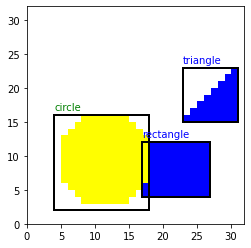

In [6]:
i = np.random.randint(num_imgs)
plt.imshow(np.transpose(imgs[i], (1, 0, 2)), interpolation = 'none', origin = 'lower', extent = [0, img_size, 0, img_size])
for bbox, shape, color in zip(bboxes[i], shapes[i], colors[i]):
    plt.gca().add_patch(matplotlib.patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], lw = 2, ec = 'k', fc = 'none'))
    plt.annotate(shape_labels[shape], (bbox[0], bbox[1] + bbox[3] + 0.7), color = color_labels[color], clip_on = False)

## Preprocessing

In [7]:
X = (imgs - 128.) / 255.
X.shape, np.mean(X), np.std(X)

((50000, 32, 32, 3), 0.38592452193116783, 0.31438538862341575)

In [8]:
colors_onehot = np.zeros((num_imgs, num_objects, num_colors))
for i_img in range(num_imgs):
    for i_object in range(num_objects):
        colors_onehot[i_img, i_object, colors[i_img, i_object]] = 1

shapes_onehot = np.zeros((num_imgs, num_objects, num_shapes))
for i_img in range(num_imgs):
    for i_object in range(num_objects):
        shapes_onehot[i_img, i_object, shapes[i_img, i_object]] = 1
        
y = np.concatenate([bboxes / img_size, shapes_onehot, colors_onehot], axis = -1).reshape(num_imgs, -1)
y.shape, np.all(np.argmax(colors_onehot, axis = -1) == colors)

((50000, 30), True)

## Train Test Split

In [9]:
i = int(0.8 * num_imgs)
train_X = X[:i]
test_X = X[i:]
train_y = y[:i]
test_y = y[i:]
test_imgs = imgs[i:]
test_bboxes = bboxes[i:]

## CNN Model

In [20]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Convolution2D, MaxPooling2D, Flatten

# TODO: Maybe remove pooling bc it takes away the spatial information.

model = Sequential([
        Convolution2D(32, kernel_size = (6, 6), 
                      strides = (2, 2),
                      input_shape = (32, 32, 3),
                      padding = 'same', activation = 'relu'),
        MaxPooling2D(pool_size = (3, 3), strides = (2, 2), padding = 'same'),
        Convolution2D(64, kernel_size = (3, 3), 
                      strides = (1, 1), 
                      padding = 'same', activation = 'relu'),
        MaxPooling2D(pool_size = (3, 3), strides = (2, 2), padding = 'same'),
        Convolution2D(128, kernel_size = (3, 3), 
                      strides = (1, 1), 
                      padding = 'same', activation = 'relu'),
        Convolution2D(256, kernel_size = (3, 3), 
                      strides = (1, 1), 
                      padding = 'same', activation = 'relu'),
        MaxPooling2D(pool_size = (3, 3), strides = (2, 2), padding = 'same'),
        Flatten(),
        Dropout(0.4),
        Dense(256, activation = 'relu'),
        Dropout(0.4),
        Dense(y.shape[ - 1])
    ])

model.compile('adam', 'mse')
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_34 (Conv2D)           (None, 16, 16, 32)        3488      
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 8, 8, 64)          18496     
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 4, 4, 64)          0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 4, 4, 128)         73856     
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 4, 4, 256)         295168    
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 2, 2, 256)        

## IoU Calculating Function

In [21]:
def IOU(bbox1, bbox2):
    '''Calculate overlap between two bounding boxes [x, y, w, h] as the area of intersection over the area of unity'''
    x1, y1, w1, h1 = bbox1[0], bbox1[1], bbox1[2], bbox1[3]  # TODO: Check if its more performant if tensor elements are accessed directly below.
    x2, y2, w2, h2 = bbox2[0], bbox2[1], bbox2[2], bbox2[3]

    w_I = min(x1 + w1, x2 + w2) - max(x1, x2)
    h_I = min(y1 + h1, y2 + h2) - max(y1, y2)
    if w_I <= 0 or h_I <= 0:  # no overlap
        return 0
    I = w_I * h_I

    U = w1 * h1 + w2 * h2 - I

    return I / U

## Distance Calculating Function

In [22]:
def distance(bbox1, bbox2):
    return np.sqrt(np.sum(np.square(bbox1[:2] - bbox2[:2])))

## Training

In [23]:
num_epochs = 50
iou_max = 0.
fact = math.factorial(num_objects)

flipped_train_y = np.array(train_y)
flipped = np.zeros((len(train_y), num_epochs))
ious_epochs = np.zeros((len(train_y), num_epochs))
dists_epochs = np.zeros((len(train_y), num_epochs))
mses_epochs = np.zeros((len(train_y), num_epochs))
acc_shapes_epoch = np.zeros((len(train_y), num_epochs))
acc_colors_epoch = np.zeros((len(train_y), num_epochs))

# TODO: Calculate ious directly for all samples (using slices of the array pred_y for x, y, w, h).
for epoch in range(num_epochs):
    print('Epoch', epoch)
    model.fit(train_X, flipped_train_y, epochs = 1, validation_data = (test_X, test_y), verbose = 1)
    pred_y = model.predict(train_X)

    for i, (pred_bboxes, exp_bboxes) in enumerate(zip(pred_y, flipped_train_y)):
        
        pred = pred_bboxes.reshape(num_objects, -1)
        exp = exp_bboxes.reshape(num_objects, -1)
        p_exp = list(permutations(exp))
        
        # ignore the shape value
        pred_bboxes = pred[:, :4]
        exp_bboxes = exp[:, :4]
        
        p_exp_bboxes = list(permutations(exp_bboxes))
        ious = np.zeros((fact, num_objects))
        dists = np.zeros((fact, num_objects))
        mses = np.zeros((fact, num_objects))
        p_ious = np.zeros(fact)
        p_mses = np.zeros(fact)
        p_dists = np.zeros(fact)
        
        for j, exp_bboxes in enumerate(p_exp_bboxes):
            exp_bboxes = list(exp_bboxes) 
            for k in range(num_objects):
                ious[j, k] = IOU(exp_bboxes[k], pred_bboxes[k])
                dists[j, k] = distance(exp_bboxes[k], pred_bboxes[k])
                mses[j, k] = np.mean(np.square(exp_bboxes[k] - pred_bboxes[k]))
            p_ious[j] = sum(ious[j, :])
            p_dists[j] = sum(dists[j, :])
            p_mses[j] = sum(mses[j, :])
            
        keymax = p_mses.argmin()
        ious_epochs[i, epoch] += p_ious[keymax] / num_objects
        dists_epochs[i, epoch] += p_dists[keymax] / num_objects
        mses_epochs[i, epoch] += p_mses[keymax] / num_objects
        
        flipped_train_y[i] = np.array(p_exp[keymax]).flatten()
        if keymax != 0:
            flipped[i, epoch] = 1.
        
        if p_ious[keymax] > iou_max:
            model.save('Colored_Multiple_Shapes_model.h5')
            iou_max = p_ious[keymax]
        
        acc_shapes_epoch[i, epoch] = np.mean(np.argmax(pred[:, 4:4 + num_shapes], axis = -1) == np.argmax(exp[:, 4:4 + num_shapes], axis = -1))
        acc_colors_epoch[i, epoch] = np.mean(np.argmax(pred[:, 4 + num_shapes:4 + num_shapes + num_colors], axis = -1) == np.argmax(exp[:, 4 + num_shapes:4 + num_shapes + num_colors], axis = -1))    
            
    print('Flipped {} % of all elements'.format(np.mean(flipped[:, epoch]) * 100.))
    print('Mean IOU: {}'.format(np.mean(ious_epochs[:, epoch])))
    print('Mean dist: {}'.format(np.mean(dists_epochs[:, epoch])))
    print('Mean mse: {}'.format(np.mean(mses_epochs[:, epoch])))
    print('Accuracy shapes: {}'.format(np.mean(acc_shapes_epoch[:, epoch])))
    print('Accuracy colors: {}'.format(np.mean(acc_colors_epoch[:, epoch])))
    
# training starts from 21:47

Epoch 0
1250/1250 [==============================] - 22s 17ms/step - loss: 0.1299 - val_loss: 0.1203
Flipped 83.005 % of all elements
Mean IOU: 0.23089664647649297
Mean dist: 0.21525564730222954
Mean mse: 0.01732701068687949
Accuracy shapes: 0.5400166666666667
Accuracy colors: 0.5440833333333333
Epoch 1
1250/1250 [==============================] - 22s 17ms/step - loss: 0.1131 - val_loss: 0.1226
Flipped 34.582499999999996 % of all elements
Mean IOU: 0.2945896060622477
Mean dist: 0.1780676218478496
Mean mse: 0.013054884621320534
Accuracy shapes: 0.7088749999999998
Accuracy colors: 0.6078
Epoch 2
1250/1250 [==============================] - 22s 17ms/step - loss: 0.0995 - val_loss: 0.1301
Flipped 19.43 % of all elements
Mean IOU: 0.31339821333273604
Mean dist: 0.16879571019160725
Mean mse: 0.012098189833204999
Accuracy shapes: 0.7581249999999999
Accuracy colors: 0.636025
Epoch 3
1250/1250 [==============================] - 22s 17ms/step - loss: 0.0938 - val_loss: 0.1329
Flipped 15.61750000

1250/1250 [==============================] - 22s 17ms/step - loss: 0.0724 - val_loss: 0.1486
Flipped 9.6325 % of all elements
Mean IOU: 0.3557987761177433
Mean dist: 0.1492852703492449
Mean mse: 0.010281191387927748
Accuracy shapes: 0.862425
Accuracy colors: 0.7604666666666666
Epoch 29
1250/1250 [==============================] - 22s 17ms/step - loss: 0.0724 - val_loss: 0.1462
Flipped 10.0975 % of all elements
Mean IOU: 0.35035936028093495
Mean dist: 0.1498496416384353
Mean mse: 0.010352304447821896
Accuracy shapes: 0.8618833333333332
Accuracy colors: 0.7633583333333332
Epoch 30
1250/1250 [==============================] - 22s 18ms/step - loss: 0.0722 - val_loss: 0.1486
Flipped 9.0325 % of all elements
Mean IOU: 0.35725506120624567
Mean dist: 0.14980146829241736
Mean mse: 0.010324438108681161
Accuracy shapes: 0.8651583333333333
Accuracy colors: 0.7671999999999999
Epoch 31
1250/1250 [==============================] - 21s 17ms/step - loss: 0.0715 - val_loss: 0.1484
Flipped 10.7075 % of a

## Model Layers

(32, 6, 6, 3)
-0.0075885663 0.10781064 -0.3591065 0.30483738
126.064926 27.491716 36.42784 205.73352


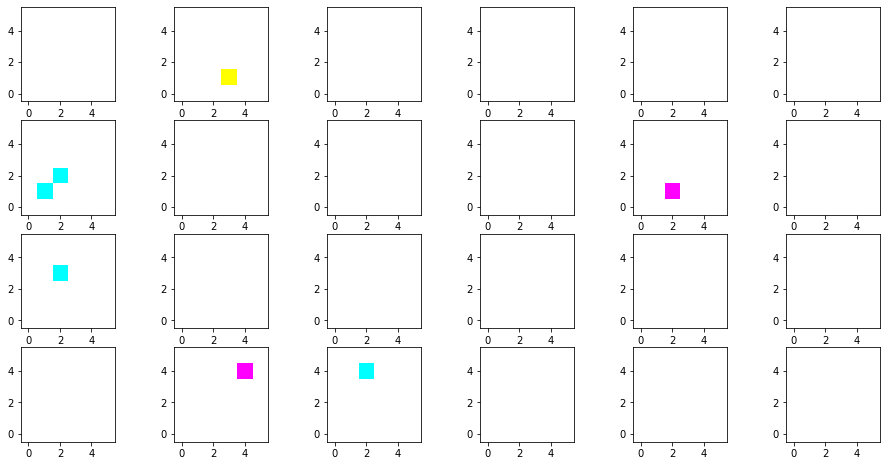

In [38]:
# model.layers
weights = model.layers[0].get_weights()[0]
weights = weights.transpose(3, 0, 1, 2)
print(weights.shape)
# plt.imshow(weights[0] * 255. + 128., interpolation='none', origin='lower')
print(np.mean(weights[0]), np.std(weights[0]), np.min(weights[0]), np.max(weights[0]))
adj_weights = (weights * 255.) + 128.
print(np.mean(adj_weights[0]), np.std(adj_weights[0]), np.min(adj_weights[0]), np.max(adj_weights[0]))
plt.figure(figsize = (16, 8))
for i in range(24):
    plt.subplot(4, 6, i + 1)
    plt.imshow(adj_weights[i, :, :], interpolation = 'none', origin = 'lower', cmap = 'Greys')

## Flipping Track

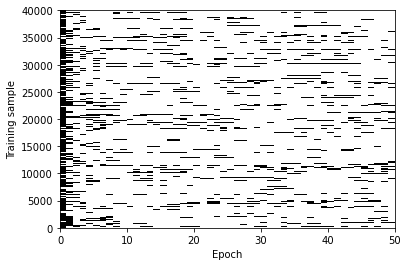

In [25]:
plt.pcolormesh(flipped[:, :], cmap = 'Greys')
plt.xlabel('Epoch')
plt.ylabel('Training sample')
plt.savefig('colored_multiple_shapes_flips.png', dpi = 100)
plt.show()

## Metrics Track

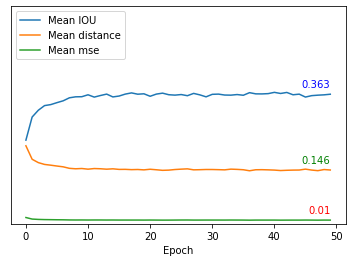

In [27]:
mean_ious_epoch = np.mean(ious_epochs, axis = 0)
mean_dists_epoch = np.mean(dists_epochs, axis = 0)
mean_mses_epoch = np.mean(mses_epochs, axis = 0)
plt.plot(mean_ious_epoch, label = 'Mean IOU')  # between predicted and assigned true bboxes
plt.plot(mean_dists_epoch, label = 'Mean distance')  # relative to image size
plt.plot(mean_mses_epoch, label = 'Mean mse')  # relative to image size
plt.annotate(np.round(np.max(mean_ious_epoch), 3), (len(mean_ious_epoch) - 1, mean_ious_epoch[-1] + 0.02), horizontalalignment = 'right', color = 'b')
plt.annotate(np.round(np.min(mean_dists_epoch), 3), (len(mean_dists_epoch) - 1, mean_dists_epoch[-1] + 0.02), horizontalalignment = 'right', color = 'g')
plt.annotate(np.round(np.min(mean_mses_epoch), 3), (len(mean_mses_epoch) - 1, mean_mses_epoch[-1] + 0.02), horizontalalignment = 'right', color = 'r')

plt.xlabel('Epoch')
plt.legend(loc = 'upper left')
plt.ylim(0, 0.6)
ax = plt.gca()
ax.axes.yaxis.set_visible(False)
plt.savefig('training_metrics.png', dpi = 100)

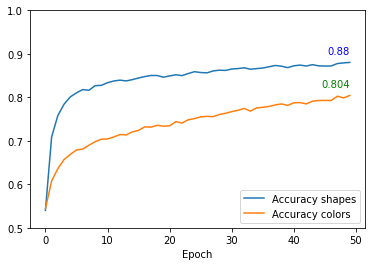

In [28]:
mean_acc_shapes_epoch = np.mean(acc_shapes_epoch, axis = 0)
mean_acc_colors_epoch = np.mean(acc_colors_epoch, axis = 0)
plt.plot(mean_acc_shapes_epoch, label = 'Accuracy shapes')  # between predicted and assigned true bboxes
plt.plot(mean_acc_colors_epoch, label = 'Accuracy colors')
plt.annotate(np.round(np.max(mean_acc_shapes_epoch), 3), (len(mean_acc_shapes_epoch)-1, mean_acc_shapes_epoch[-1] + 0.02), horizontalalignment = 'right', color = 'b')
plt.annotate(np.round(np.max(mean_acc_colors_epoch), 3), (len(mean_acc_colors_epoch)-1, mean_acc_colors_epoch[-1] + 0.02), horizontalalignment = 'right', color = 'g')

plt.xlabel('Epoch')
plt.legend(loc = 'lower right')
plt.ylim(0.5, 1)

plt.savefig('training_metrics_classification.png', dpi = 100)

## Denormalize Data

In [32]:
pred_y = model.predict(test_X)
pred_y = pred_y.reshape(len(pred_y), num_objects, -1)
pred_bboxes = pred_y[..., :4] * img_size
pred_shapes = np.argmax(pred_y[..., 4:4 + num_shapes], axis = -1).astype(int)  # take max from probabilities
pred_colors = np.argmax(pred_y[..., 4 + num_shapes:4 + num_shapes + num_colors], axis = -1).astype(int)
pred_bboxes.shape, pred_shapes.shape, pred_colors.shape

((10000, 3, 4), (10000, 3), (10000, 3))

## Visualize Results

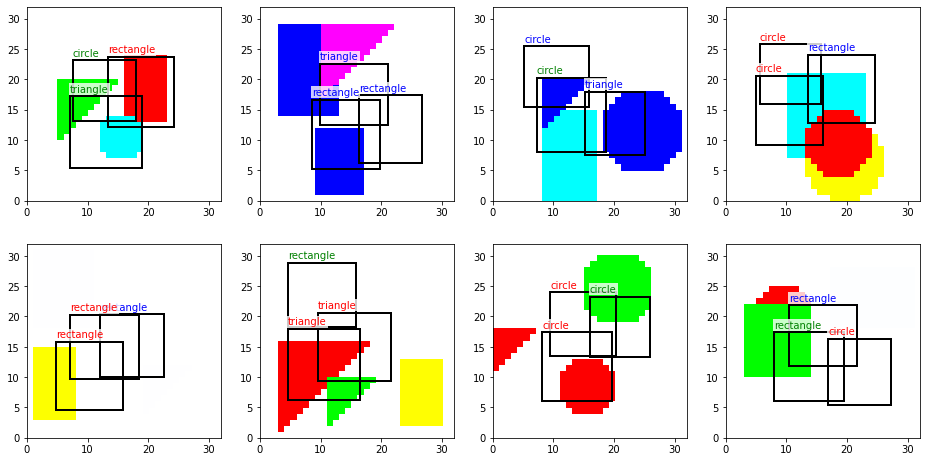

In [36]:
plt.figure(figsize = (16, 8))
for i_subplot in range(1, 9):
    plt.subplot(2, 4, i_subplot)
    i = np.random.randint(len(test_X))
    plt.imshow(test_imgs[i], interpolation = 'none', origin = 'lower', extent = [0, img_size, 0, img_size])
    for bbox, shape, color in zip(pred_bboxes[i], pred_shapes[i], pred_colors[i]):
        plt.gca().add_patch(matplotlib.patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], lw = 2, ec = 'k', fc = 'none'))
        plt.annotate(shape_labels[shape], (bbox[0], bbox[1] + bbox[3] + 0.7), color = color_labels[color], clip_on = False, bbox = {'fc': 'w', 'ec': 'none', 'pad': 1, 'alpha': 0.8})

In [35]:
np.mean(pred_bboxes[:, :, 2]), np.std(pred_bboxes[:, :, 2])

(10.911018, 0.63509977)

## Overall Assessment

In [37]:
from keras.models import load_model
fact = math.factorial(num_objects)
model_test = load_model('Colored_Multiple_Shapes_model.h5')
pred_y = model_test.predict(test_X)
sum_iou = 0.
sum_dist = 0.
sum_mse = 0.
test_y = np.array(test_y)

for pred_bboxes, test_bboxes in zip(pred_y, test_y):
    
    pred_bboxes = pred_bboxes.reshape(num_objects, -1)
    test_bboxes = test_bboxes.reshape(num_objects, -1)
    
    p_test_bboxes = list(permutations(test_bboxes))
    p_ious = np.zeros(fact)
    p_dists = np.zeros(fact)
    p_mses = np.zeros(fact)
    ious = np.zeros((fact, num_objects))
    dists = np.zeros((fact, num_objects))
    mses = np.zeros((fact, num_objects))
    
    for j, test_bboxes in enumerate(p_test_bboxes):
        test_bboxes = list(test_bboxes) 
        for k in range(num_objects):
            ious[j, k] = IOU(test_bboxes[k], pred_bboxes[k])
            dists[j, k] = distance(test_bboxes[k], pred_bboxes[k])
            mses[j, k] = np.mean(np.square(test_bboxes[k] - pred_bboxes[k]))
        p_ious[j] = sum(ious[j, :])
        p_dists[j] = sum(dists[j, :])
        p_mses[j] = sum(mses[j, :])
            
    keymax = p_ious.argmax()
    sum_iou += p_ious[keymax] 
    sum_dist += p_dists[keymax] 
    sum_mse += p_mses[keymax] 

mean_iou = sum_iou / (num_objects * len(pred_y))
mean_dist = sum_dist / (num_objects * len(pred_y))
mean_mse = sum_mse / (num_objects * len(pred_y))
print('IoU:', mean_iou)
print('Distance:', mean_dist)
print('MSE:', mean_mse)

IoU: 0.36439285416456846
Distance: 0.1561918434137123
MSE: 0.07687554081672043
